In [34]:
import matplotlib.pyplot as plt

import networkx as nx

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper

import geopandas as gpd

import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

from gerrychain.updaters import cut_edges

from gerrychain.tree import bipartition_tree, find_balanced_edge_cuts_memoization

#import maup

import numpy as np

import pandas as pd

import random

In [36]:
precincts2 = gpd.read_file('AL_Processed_Blocks_2.shp')

In [39]:
precincts2.head()

,GEOID20,STATEFP,COUNTYFP,PRECINCTID,VAP_MOD,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRTUB,...,G20PSCDCAS,G20PSCOWRI,P0010001,P0010003,P0010004,population,CON22,C_X,C_Y,geometry
0,010010201001000,01,001,01001000016,14,5.79,2.56,0.11,0.04,5.68,...,2.62,0.01,21,12,4,21,5,-86.480483,32.470695,"POLYGON ((-86.48558 32.47074, -86.48456 32.471..."
1,010010201001001,01,001,01001000016,26,10.75,4.76,0.20,0.07,10.54,...,4.86,0.03,34,18,11,34,5,-86.481658,32.468173,"POLYGON ((-86.48644 32.47090, -86.48572 32.470..."
2,010010201001002,01,001,01001000016,27,11.17,4.95,0.21,0.07,10.95,...,5.05,0.03,29,24,2,29,5,-86.491657,32.470307,"POLYGON ((-86.49551 32.47404, -86.49478 32.473..."
3,010010201001003,01,001,01001000016,16,6.62,2.93,0.12,0.04,6.49,...,2.99,0.02,17,16,0,17,5,-86.501637,32.471481,"POLYGON ((-86.51038 32.47225, -86.51031 32.472..."
4,010010201001004,01,001,01001000016,0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0,0,0,0,5,-86.500606,32.467611,"POLYGON ((-86.50189 32.46813, -86.50158 32.468..."


In [2]:
graph = Graph.from_json('AL_Processed_Precincts.json')

In [3]:
precincts = gpd.read_file('AL_Processed_Precincts.shp')

In [4]:
for node in graph.nodes():
    graph.nodes[node]["pp"] = graph.nodes[node]["G20PREDBID"]/(graph.nodes[node]["G20PREDBID"]+graph.nodes[node]["G20PRERTRU"]+1)

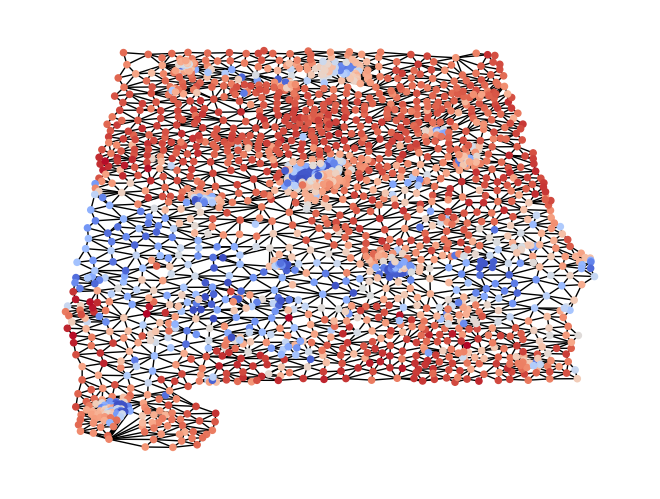

In [5]:
nx.draw(graph,pos = {x:(graph.nodes[x]['C_X'],graph.nodes[x]['C_Y']) for x in graph.nodes()},
        node_size=20,node_color=[graph.nodes[x]['pp'] for x in graph.nodes()],cmap='coolwarm_r')

In [6]:
precincts['pp']= precincts['G20PREDBID']/(precincts['G20PREDBID']+ precincts['G20PRERTRU']+ 1)

(-88.65247604999999, -84.70899695, 29.901244849999998, 35.25120815)

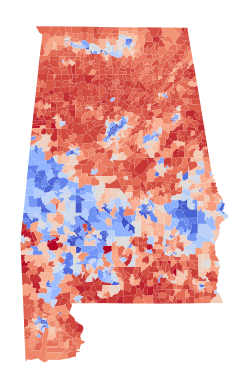

In [7]:
precincts.plot(column='pp',cmap='coolwarm_r')
plt.axis('off')

In [8]:
def county_splits(part):

  ad = dict(part.assignment)


  precincts['current'] = precincts['PRECINCTID'].map(ad)

  return sum(precincts.groupby('COUNTYFP')['current'].nunique() >1)



In [9]:
total_population = 0

for node in graph.nodes():
    total_population += graph.nodes()[node]['population']


In [10]:

my_updaters = {
    "population": updaters.Tally("population", alias="population"),
    "cut_edges": cut_edges,
    "PP":polsby_popper,
    "county_splits":county_splits
}


num_elections = 2



election_names = [
    "PRES",
    "BPOP",
]

election_columns = [
    ["G20PREDBID", "G20PRERTRU"],
    ["P0010004", "P0010003"],
]


elections = [
    Election(
        election_names[i],
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)


In [11]:
con_part = GeographicPartition(graph,recursive_tree_part(graph, range(7),total_population/7, "population", .02, 1),my_updaters)

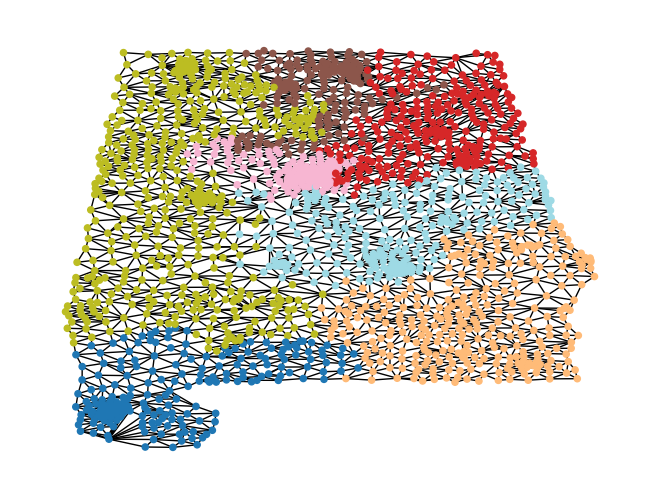

In [12]:
ad = dict(con_part.assignment)
nx.draw(graph,pos = {x:(graph.nodes[x]['C_X'],graph.nodes[x]['C_Y']) for x in graph.nodes()},
    node_size=20,node_color=[ad[x] for x in graph.nodes()],cmap='tab20')


In [13]:
econ_part = GeographicPartition(graph,"CON",my_updaters)


In [14]:
con_part['county_splits']

29

In [17]:
ideal_con_population = sum(con_part["population"].values()) / len(con_part)


recom_con_proposal = partial(recom, pop_col="population", pop_target=ideal_con_population, epsilon=0.02)


compactness_psc_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]), 1.3*len(con_part['cut_edges']))


np.mean([abs((x-ideal_con_population))/ideal_con_population for x in list(con_part['population'].values())])

0.009775162338146995

In [18]:
np.mean([abs((x-ideal_con_population))/ideal_con_population for x in list(con_part['population'].values())])

0.009775162338146995

In [22]:
exp_con_chain = MarkovChain(
    proposal=recom_con_proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(con_part, 0.02),
          #constraints.single_flip_contiguous
    ],
    accept=accept.always_accept,#town_accept,#pp_accept,
    initial_state=con_part,
    total_steps=10000
  )



In [25]:
step = 0


pps = []
ces = []
cs = []

pres20 = []
wins = []
mm = []
eg = []
bpop = []
bmaj = []




for part in exp_con_chain:
    
    pps.append(part['PP'])
    ces.append(len(part['cut_edges']))
    cs.append([part['county_splits']])
    pres20.append(sorted(list(part['PRES'].percents("First"))))
    wins.append(part['PRES'].wins('First'))
    mm.append(mean_median(part['PRES']))
    eg.append(efficiency_gap(part['PRES']))
    bpop.append(sorted(list(part['BPOP'].percents("First"))))
    bmaj.append(sum([x>.5 for x in bpop[-1]]))
    
    if step %100 == 0:
    
        ad = dict(part.assignment)

        ppd = {x:part['PRES'].percent("First",race=x) for x in range(7)}

        nx.draw(graph,pos = {x:(graph.nodes[x]['C_X'],graph.nodes[x]['C_Y']) for x in graph.nodes()},
            node_size=20,node_color=[ppd[ad[x]] for x in graph.nodes()],cmap='coolwarm_r',vmin=0,vmax=1)
        plt.savefig(f"./run3/con1n_{step}.png")
        plt.close()

        nx.draw(graph,pos = {x:(graph.nodes[x]['C_X'],graph.nodes[x]['C_Y']) for x in graph.nodes()},
            node_size=20,node_color=[ad[x] for x in graph.nodes()],cmap='tab20',vmin=0,vmax=1)
        plt.savefig(f"./run3/con1p_{step}.png")
        plt.close()


        precincts['current'] = precincts['PRECINCTID'].map(ad)

        precincts['partisan'] = precincts['current'].map(ppd)

        precincts.plot(column='partisan',cmap='coolwarm_r',vmin=0,vmax=1)
        plt.axis('off')
        plt.savefig(f"./run3/con1_{step}.png")
        plt.close()

        precincts.plot(column='current',cmap='tab20')
        plt.axis('off')
        plt.savefig(f"./run3/con1d_{step}.png")
        plt.close()

    
    step += 1
    
    

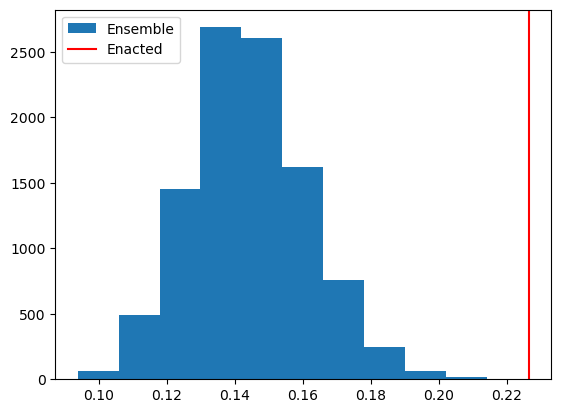

In [27]:
plt.hist([np.mean(list(pps[x].values())) for x in range(len(pps))],label='Ensemble')
plt.axvline(np.mean(list(econ_part['PP'].values())),color='red',label="Enacted")
plt.legend()
plt.savefig(f"./fig/hist_polby_poppers")

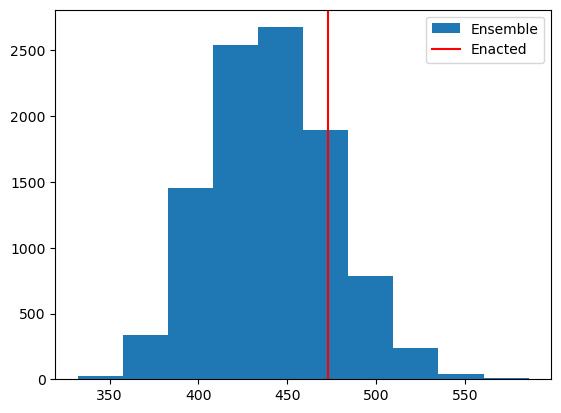

In [28]:
plt.hist(ces,label='Ensemble')
plt.axvline(len(econ_part['cut_edges']),color='red',label="Enacted")
plt.legend()
plt.savefig(f"./fig/hist_cut_edges")

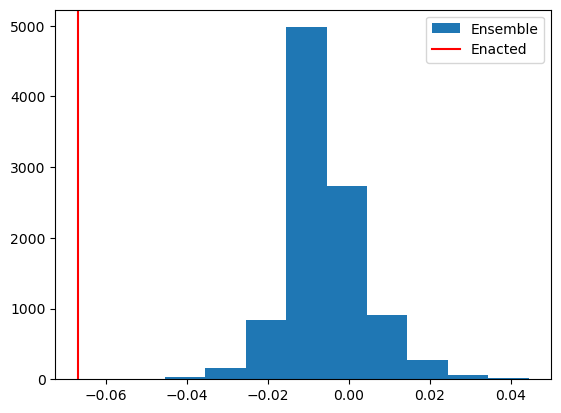

In [29]:
plt.hist(mm,label='Ensemble')
plt.axvline(mean_median(econ_part['PRES']),color='red',label="Enacted")
plt.legend()
plt.savefig(f"./fig/hist_pres")

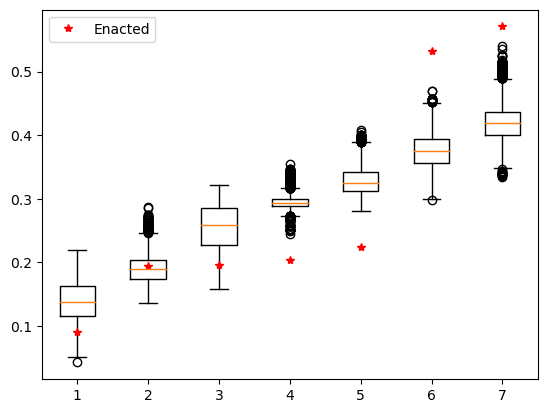

In [30]:
plt.boxplot(np.array(bpop))
plt.plot([1,2,3,4,5,6,7],sorted(econ_part['BPOP'].percents("First")),"*",label='Enacted',color='red')
plt.legend()
plt.savefig(f"./fig/box_plot_black_pop")

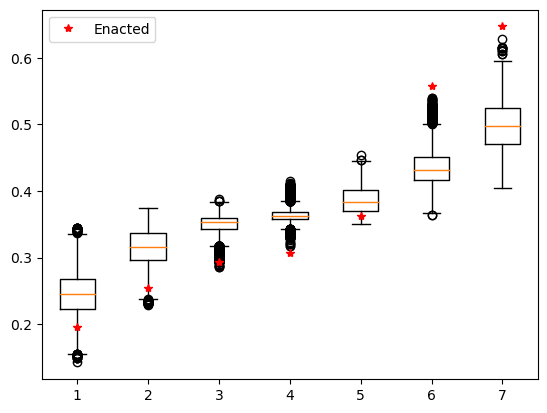

In [31]:
plt.boxplot(np.array(pres20))
plt.plot([1,2,3,4,5,6,7],sorted(econ_part['PRES'].percents("First")),"*",label='Enacted',color='red')
plt.legend()
plt.savefig(f"./fig/presidential_votes")